<center><h1>Making Merger Tree from m3p output</h1></center>

In [1]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
import matplotlib
importlib.reload(m3p_merger)

<module 'm3p_merger' from 'C:\\Users\\David\\Google Drive\\Axion PhD\\PeakPatch\\m3p_merger\\m3p_merger.py'>

In [2]:
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)


In [3]:
#ppFile = pathPrefix+"../inputs/"+"inputs.ax_manyz"
ppFile = "inputs.ax_stitched"
peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, printOutput = True)

	Loading file (100 of 100): axOut/final/sorted/axion_final_halos_99.hdf5


In [5]:
peak_list_main.shape

(100,)

<h2><center>Find which trees are interesting</center></h2>

In [9]:
out = m3p_merger.BuildMergerTree(peak_list_main, ppFile, redshift_indicies='all')

In [10]:
for i in range(len(out)):
    mass = out[i][0][0][-1]
    mask = (mass>1e-12)*(mass<1e-11)
    if mask:
        print(i, end = ' ')
    

140 185 310 328 488 806 889 940 1025 1050 1119 1189 1201 1255 1366 1373 1388 1415 1469 1511 1590 1738 1903 1996 2153 2261 2278 2453 2517 2563 2664 2708 2713 2804 2898 2925 2941 2958 2981 3006 3034 3119 3154 3194 3243 3268 3436 3459 3461 3485 3522 3607 3731 3808 3846 3912 4162 4208 

<h2><center>Calculate Merger Tree</center></h2>

In [5]:
peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, massType = "unstripped")
out = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = 185)
np.save("./FinalGraphs/Data/MergerTreeExample.npy",out[0])

In [12]:
importlib.reload(m3p_merger)
out2 = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = 140)

<h2><center>Plot all peaks on each other</center></h2>

In [ ]:
importlib.reload(m3p_merger)
#out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 797, printOutput = True)
m3p_merger.plotMergerPatches(out2[0][::10], ppFile, cmap = "viridis")

<h2><center>Plot merger tree</center></h2>

	Final redshift index 99 out of 100
	i.e. Earlist halo at z = 1000000.0
	Halo 0 of 1: 99 complete of 99
Got to here


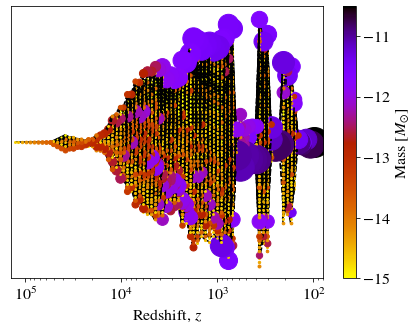

In [4]:
importlib.reload(m3p_merger)
ppFile = "inputs.ax_stitched"
index = 185 

# # Plot merger tree using 'normal' mass
# peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, massType = "normal")
# out2 = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = index)
# fig = m3p_merger.plotMergerTree(out2[0], ppFile, startIndex=0, font_size = 16, log = True,
#                           colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")
# plt.show()

# Plot merger tree using 'unstripped' mass
peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, massType = "unstripped")
out2 = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = index,
                                   printOutput = True)
print("Got to here")
fig = m3p_merger.plotMergerTree(out2[0], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")

<h3>Checking Progenitor mass calculation</h3>

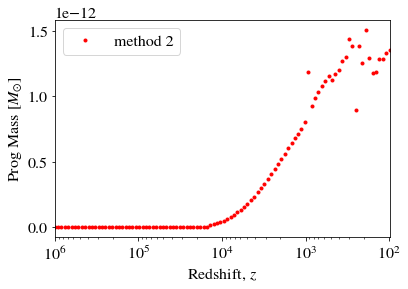

In [9]:
importlib.reload(m3p_merger)
ppFile = "inputs.ax_stitched"

halo_index = 488  

f = 0.01
# peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, massType = "normal")
# out = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = halo_index)
# zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
# plt.semilogx(z, ProgMass, 'b.', ms=6, label = "method 1")

peak_list_main, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, massType = "unstripped")
out = m3p_merger.BuildMergerTree2(peak_list_main, ppFile, final_halos_indicies = halo_index)
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, 'r.', ms=6, label ="method 2")

plt.legend(loc=2)
plt.xlim(max(z), min(z))
plt.ylabel("Prog Mass [$M_{\odot}$]")
plt.xlabel("Redshift, $z$")

np.save("./FinalGraphs/Data/MassGrowth.npy", [z, ProgMass, zCol])

In [49]:
importlib.reload(m3p_merger)
ppFile = "inputs.axbig_manyz3"

frac = 0.01
startIndicies = [0]

for i, startIndex in enumerate(startIndicies):  
    z0 = 99.0
    
    print("-"*40)
    print("Calculating collapse redshifts\n   ppFile: {}\n   z0={:.3}\n".format(ppFile, z0))
    
    print("Building peak list...")
    peak_list, boxsize = m3p_merger.MakePeakList(ppFile, startIndex = startIndex, printOutput = True)
    print("Done.\n")

    print("Building merger trees...")
    out = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = "all", printOutput = True)
    print("Done.\n")

    print("Calculating collapse redshifts...")
    collapse_redshifts = np.zeros(len(out))
    for i in range(len(out)):
        collapse_redshifts[i] = m3p_merger.FindCollapseRedshift(out[i], frac, ppFile, interp = "None")[0]
    print("Done.\n")

    print("Fetching final halo masses...")
    masses = np.zeros(len(out))
    for i in range(len(out)):
        masses[i] = out[i][0][0,4]
    print("Done.\n")

    print("Fetching final halo radii...")
    radii = np.zeros(len(out))
    for i in range(len(out)):
        radii[i] = out[i][0][0,3]
    print("Done.\n")

    print("Saving data...")
    np.save("ConcEvolution/axbig3_manyz_CollapseRedshifts_z0_{}".format(z0), collapse_redshifts)
    np.save("ConcEvolution/axbig3_manyz_FinalMasses_z0_{}".format(z0), masses)
    np.save("ConcEvolution/axbig3_manyz_FinalRadii_z0_{}".format(z0), radii)
    print("Done.\n")

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz3
   z0=99.0

Building peak list...
	Loading file (109 of 109): axOut/big3/axion_big3final_halos_108.hdf5
Done.

Building merger trees...
	Final redshift index 108 out of 109
	i.e. Earlist halo at z = 1000000.0


KeyboardInterrupt: 